In [1]:
import re
import pickle
import copy
import uuid
from unicodedata import normalize
from string import punctuation
import warnings
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.corpus import machado, mac_morpho, floresta
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance, euclidean_distance
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from pyclustering.cluster.xmeans import xmeans, kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import HTML

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [2]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                if palavra.pos_ == "VERB":
                    try:
                        word = VERBOS[word]
                    except:
                        word = palavra.lemma_
                else:
                    word = palavra.lemma_
                clean_frase += [remover_acentos(word)]
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return clean_frase

def _get_stopwords():
    stpwords = sorted(list(set(stopwords.words('portuguese') + list(NLP.Defaults.stop_words) + list(punctuation))))
    rms = ["um", "uma", "não", "mais", "muito", "você"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

# NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
NLP = spacy.load('pt_core_news_sm')
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

VERBOS = {}
with open("../verbs.pkc", "rb") as infile:
    verbos = pickle.load(infile)
    for verb in verbos:
        for v in list(verb.values())[0]:
            VERBOS[v] = list(verb.keys())[0]
    
colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7) # , (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

In [3]:
kmin = 5
kmax = 40

In [4]:
df_data = pd.read_csv("gnews.csv", sep=';', names=["title", "description"])
df_data.dropna(inplace=True)

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(HTML(df_data.iloc[index].sort_values(by=["title"]).to_html(index=False)))

title,description
Confira o provável setlist do show Amigos,"Na noite deste sábado, na Arena do Grêmio, Chitãozinho & Xororó, Zezé di Camargo & Luciano e Leonardo apresentam o show Amigos 20 Anos - A História Continua, que faz um passeio nos sucessos dos sertanejos. O primeiro show da turnê foi em julho, em Be"
Crítica | A Grande Mentira (2019): verdadeiros atores,"Dois idosos se conhecem num site para encontros românticos. Ao se encontrarem, revelam que mentiram sobre seus nomes. Isso acaba quebrando o gelo entre o casal e dá início a um relacionamento de intimidade de tal nível que a recém-viúva não hesita em hospedá-"
Fã cria arte da versão sombria da Capitã Marvel,"O artista BossLogic decidiu alterar suas obras com Brie Larson para criar a versão ‘live action’ da Capitã Marvel que está matando os Vingadores nos quadrinhos. E o resultado pode ser visto abaixo:Reworked one of my #captainmarvel pieces, made it a little d"
Google vai matar o Cloud Print e dá um ano aos utilizadores para encontrarem alternativa,"Muitos não perceberam a utilidade de ter um serviço cloud para imprimir remotamente. Alguns guias de utilização mostraram o poder deste serviço gratuito da Google. Contudo, nem todos os serviços conseguem vingar. Assim, num ano em que houve a morte do Inbox,"
"Guedes defende zerar INSS para empresários, mas não diz quem pagará a conta","Foto: Pedro Ladeira/FolhapressO ministro da Economia, Paulo Guedes, afirmou que é possível criar milhões de empregos se os encargos trabalhistas forem zerados, em um evento empresarial nesta sexta (22), no Rio de Janeiro, de acordo o jornal Valor Econôm"
"MacMagazine no Ar #347: evento em 2/12, teclado do MacBook Pro de 16″, AirPods Pro vs. Galaxy Buds, Donald Trump e mais!","E hoje é dia de MacMagazine no Ar! 😀 Esta é a 347ª edição do nosso podcast.PodPesquisa 2019A Associação Brasileira de Podcasters (ABPod) está realizando a PodPesquisa 2019, a fim de desenhar o perfil do ouvinte de podcast brasileiro.Ela ficará no ar at"
"PCP marca congresso para 27, 28 e 29 de novembro de 2020","O secretário-geral do PCP, Jerónimo de Sousa, anunciou hoje, em Lisboa, que vai marcar o XXI congresso do partido para 27, 28 e 29 de novembro de 2020, sustentando que o país mantém os mesmos graves problemas estruturais.Jerónimo de Sousa falava numa conf"
Palcos da semana,"Os próximos dias trazem Gregorio Duvivier num Sísifo hiperligado, o regresso dos Vampire Weekend, os finalistas ao Prémio Sonae Media Art, Akram Khan em danças de guerra e o comunismo em palco com Wen Hui e Jana Svobodová."
"Pressionado, Facebook avalia mudanças em regras para anúncios políticos","RIO Após as decisões de GoogleeTwitter, de restringir osanúncios políticos, oFacebookestá considerando alterações em suas regras, informaram fontes ao Wall Street Journal. Segundo elas, a companhia está pensando em aumentar o número mínimo de"
"Protocolo de segurança, limpeza espiritual e até manual para a família: os preparativos dos rubro-negros para a final da Libertadores","Às vésperas da decisão mais importante dos últimos 38 anos, todo cuidado é pouco. Esse tem sido o mantra dos rubro-negros, que não economizam em simpatias, correntes de WhatsApp e superstições para ver o Flamengo conquistar o bi da Libertadores. Entre as br"


In [5]:
def doc2token(doc):
    if isinstance(doc, list):
        doc = " ".join(doc)
    return TaggedDocument(tokenizer(doc), [str(uuid.uuid4())])

print("Tokenization...")
docs = set(df_data["title"])
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    documents_d2c = list(exc.map(doc2token, docs, chunksize=100))
print("Qtd documentos treino: ", len(documents_d2c))
print("Finished...")

Tokenization...
Qtd documentos treino:  3074
Finished...


In [6]:
documents_d2c[:10]

[TaggedDocument(words=['um', 'votar', 'novembro'], tags=['4922c4db-375d-46eb-a8ea-469e42106be1']),
 TaggedDocument(words=['vender', 'ativos', 'lucrar', 'maior', 'estatal', 'avancar', '69,6'], tags=['31aedd82-9647-4212-99da-0f5a065d2710']),
 TaggedDocument(words=['entrevisto', 'bolar', 'tecnico', 'ciume', 'jesus', 'acontecer'], tags=['ed8ec711-ed6e-4cbe-afcb-395d0d588819']),
 TaggedDocument(words=['investigador', 'encontrar', 'caracteristico', 'mussolini', 'chegar', 'vox'], tags=['2b8f5f1b-fb10-468f-a484-4297caf4c2e7']),
 TaggedDocument(words=['the', 'witcher', 'temporada', 'confirmar', 'netflix', 'estrear', 'serie'], tags=['e0faeac2-3d1c-45fe-9f66-d6c2862a56c8']),
 TaggedDocument(words=['duro', 'realidade', 'saudar', 'publico', 'chile', 'voce', 'nao', 'dinheiro', 'morrer'], tags=['09f5a5f9-2eff-4afc-a5e0-f4981ef05b8d']),
 TaggedDocument(words=['apple', 'desenvolver', 'aplicativo', 'windows'], tags=['393ed1fb-bc2e-4d4b-9349-1d15c1032f61']),
 TaggedDocument(words=['klabin', 'esperar', 'r

In [7]:
print("building vocab...")
vocab = copy.deepcopy(documents_d2c)
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    print("Adding machado...")
    vocab += list(exc.map(doc2token, utils.shuffle(machado.sents(), n_samples=5000), chunksize=500))
    print("Adding mac_morpho...")
    vocab += list(exc.map(doc2token, utils.shuffle(mac_morpho.sents(), n_samples=5000), chunksize=500))
    print("Adding floresta...")
    vocab += list(exc.map(doc2token, utils.shuffle(floresta.sents(), n_samples=5000), chunksize=500))
print("finish...")

building vocab...
Adding machado...
Adding mac_morpho...
Adding floresta...
finish...


In [8]:
len(vocab)

18074

In [9]:
dim = 750
epochs = 200

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")

Dimensions   : 750
Epochs       : 200


In [10]:
# print("Starting model...")
# common_kwargs = dict(
#     dm=0, vector_size=dim, epochs=epochs, workers=cpu_count(), 
#     window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
#     hs=1, negative=7, dbow_words=1, sample=0
# )
# d2v = Doc2Vec(**common_kwargs)
# print("Building vocab...")
# d2v.build_vocab(vocab)
# print("Training...")
# d2v.train(
#     documents_d2c,
#     total_examples=d2v.corpus_count,
#     epochs=d2v.epochs
# )
# print("Finish...")


from gensim.test.test_doc2vec import ConcatenatedDoc2Vec


common_kwargs = dict(
    vector_size=dim, epochs=epochs, workers=cpu_count(), 
    min_count=2, hs=0, negative=5, sample=0
)
dbow = Doc2Vec(dm=0, **common_kwargs)
print("DBOW: Building vocab...")
dbow.build_vocab(vocab)
print("DBOW: Training...")
dbow.train(
    utils.shuffle(documents_d2c),
    total_examples=dbow.corpus_count,
    epochs=dbow.epochs
)

dmm = Doc2Vec(dm=1, dm_concat=1, window=7, **common_kwargs)
print("DMM: Building vocab...")
dmm.build_vocab(vocab)
print("DMM: Training...")
dmm.train(
    utils.shuffle(documents_d2c),
    total_examples=dmm.corpus_count,
    epochs=dmm.epochs
)

d2v = ConcatenatedDoc2Vec([dbow, dmm])

print("Finish...")

DBOW: Building vocab...
DBOW: Training...
DMM: Building vocab...
DMM: Training...
Finish...


In [11]:
# X = d2v.docvecs.vectors_docs
# print(X.shape)

In [12]:
def get_doc_vector(doc):
    return d2v.docvecs[doc.tags[0]]

X = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    X = list(exc.map(get_doc_vector, documents_d2c, chunksize=100))
X = np.asarray(X)
print(X.shape)

(3074, 1500)


In [13]:
def calculate_silhouette_metric(X, K):
    km_ = KMeansClusterer(
        K, distance=cosine_distance,
        repeats=10,
        avoid_empty_clusters=True
    )
    assigned_clusters_ = np.array(km_.cluster(X, assign_clusters=True)).ravel()
    centroids = km_.means()
    sh_score = silhouette_score(X, assigned_clusters_, metric='cosine', random_state=0)
    return [len(centroids), sh_score]

print("Running Elbow...")
elbow_error = []
elbow_amount_clusters = 2
elbow_cosine_distance = np.copy(1 - cosine_similarity(X))
for _ in range(3):
    elbow_instance = elbow(elbow_cosine_distance, kmin, kmax + 1)
    elbow_instance.process()
    amc = elbow_instance.get_amount()
    if amc > elbow_amount_clusters:
        elbow_amount_clusters = amc
        elbow_error = elbow_instance.get_wce()

print("Running Silhouette...")

scores = []
silhouette_amount_clusters = 0
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    silhouette = np.asarray(list(exc.map(partial(calculate_silhouette_metric, X), range(kmin, kmax + 1), chunksize=5)))
    amount, silhouette_scores = silhouette[:, 0], silhouette[:, 1]
    silhouette_scores[np.isnan(silhouette_scores)] = -1
    silhouette_amount_clusters = int(amount[np.where(silhouette_scores == np.max(silhouette_scores))][0])

print("N. Elbow      Cluster : ", elbow_amount_clusters)
print("N. Silhouette Cluster : ", silhouette_amount_clusters)
qtd_cluster = elbow_amount_clusters if elbow_amount_clusters > silhouette_amount_clusters else silhouette_amount_clusters

Running Elbow...
Running Silhouette...
N. Elbow      Cluster :  14
N. Silhouette Cluster :  37


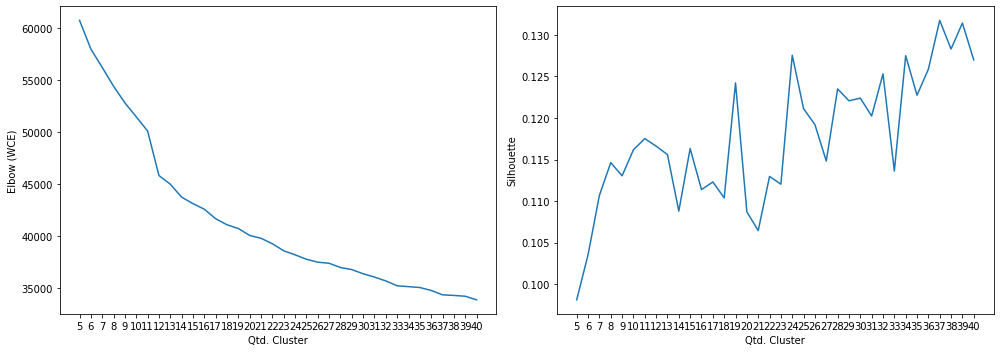

In [14]:
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(len(elbow_error)), elbow_error)
plt.xticks(range(len(elbow_error)), range(kmin, kmax + 1, 1))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Elbow (WCE)")

ax = plt.subplot(1, 2, 2)
plt.plot(range(len(silhouette_scores)), silhouette_scores)
plt.xticks(range(len(silhouette_scores)), range(kmin, kmax + 1, 1))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

In [15]:
kclusterer = KMeansClusterer(
    qtd_cluster,
    distance=cosine_distance,
    repeats=30,
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [16]:
docs = np.asarray(df_data["title"])

info = []
frases = []
for i in range(qtd_cluster):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["title", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_cluster)], np.asarray(info)[:, 1]])

print("Documentos por cluster:")
data = []
for i in range(qtd_cluster):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Qtde documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))

Documentos por cluster:


title,cluster
"Reinaldo Azevedo | APB: Bíblia, bala, antiglobalismo e hipocrisia",0
Peça ‘Audiência’ faz crítica à censura e ao totalitarismo,0
BNDES libera cartão de crédito para MEI: Descubra agora como solicitar,0
"Cidades Inteligentes em debate no Wireless Mundi, dia 21",1
Valor só dá 2 opções | Que carro comprar com aposta de Renato Gaúcho?,1
"Primeiro-ministro de Malta deve afastar-se da investigação a morte de jornalista, defende Conselho da Europa",1
Exposição 0800 exibe fotos misteriosas do britânico Mac Adams,2
Perfil de um bom gestor de bicicletarias: 9 principais atributos,2
Trump e Xi emitem sinais positivos sobre acordo inicial para neutralizar guerra comercial EUA-China,2
Sylvia Colombo | Que países podem viver tensões sociais?,3


--------------------
Qtde documentos por cluster:


C0,45
C1,27
C2,149
C3,83
C4,104
C5,43
C6,94
C7,82
C8,120
C9,54
C10,63
